<a href="https://colab.research.google.com/github/VenissaCarolQuadros/COMP551/blob/dev1/COMP551_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import numpy as np

In [2]:
def read_data(url, dest):
  response = requests.get(url)
  with open(dest, 'wb') as file:
      file.write(response.content)
  return

In [3]:
dest1= 'LinearRegression.xlsx'
read_data("https://raw.githubusercontent.com/VenissaCarolQuadros/COMP551/main/data/ENB2012_data.xlsx", dest1)
df1= pd.read_excel(dest1)

dest2= 'LogisticRegression.csv'
read_data('https://raw.githubusercontent.com/VenissaCarolQuadros/COMP551/main/data/Qualitative_Bankruptcy/Qualitative_Bankruptcy.data.txt', dest2)
df2= pd.read_csv(dest2, header=None)


In [4]:
print(df1.shape, df2.shape) ##Verifying dataset size
print( df1[df1.eq('?').any(1)],  df2[ df2.eq('?').any(1)]) #Checking for nulls
##No nulls found. Dataset size seems right

(768, 10) (250, 7)
Empty DataFrame
Columns: [X1, X2, X3, X4, X5, X6, X7, X8, Y1, Y2]
Index: [] Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6]
Index: []


##Linear Regression

In [144]:
class GradientDescent:
    
    def __init__(self, learning_rate=.0001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []                 #to store the weight history for visualization
        self.cost_history=[]
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            #print(np.linalg.norm(grad))
            grad, cost = gradient_fn(x, y, w)               # compute the gradient with present weight
            #print(cost)
            self.cost_history.append(cost)
            w = w - self.learning_rate * grad         # weight update step
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

class LinearRegression:
  def __init__(self):
    self.w=[]
  
  def editData(self):
    self.X= np.c_[np.ones((self.X).shape[0]), (self.X)] 
    return
  
  def fitClosedForm(self, X, Y):
    self.X=X
    self.Y=Y
    self.editData()
    self.w= np.linalg.inv((self.X).T @ (self.X))@ (self.X).T@ (self.Y)
    return

  """
  def fitGD(self, X, Y, iterations=1000, alpha=0.01):
    self.fitClosedForm(X, Y) #Is this a good way tp find an initial w?
    gradJ= (1/len(self.Y))*np.sum(((self.X @ self.w)- Y)*self.X)
    self.w= 

    return

  """

  def fitGD(self, X, Y, optimizer1, optimizer2):
        self.fitClosedForm(X, Y)
        def gradient(x, y, w):                          # define the gradient function
            yh =  x @ w 
            N, D = x.shape
            grad = .5*np.dot(yh - y, x)/N
            return grad, .5*np.mean((yh - y)**2)
        w0 = np.zeros(self.X.shape[1])                            # initialize the weights 
        self.w[:,0] = optimizer1.run(gradient, self.X, self.Y[:,0], w0)      # run the optimizer to get the optimal weights
        self.w[:,1] = optimizer2.run(gradient, self.X, self.Y[:,1], w0) 
        return

  def predict(self, Xt):
    Xt= np.c_[np.ones((Xt).shape[0]), (Xt)] 
    return Xt @ self.w
  
  

In [184]:
#Train test split
train=df1.sample(frac=0.8,random_state=200)
test=df1.drop(train.index)

model1= LinearRegression()

X_train= train.iloc[:, :8].to_numpy(copy=True) 
Y_train= train.iloc[:, 8:].to_numpy(copy=True)

model1.fitClosedForm(X_train, Y_train)

X_test= test.iloc[:, :8].to_numpy(copy=True)
Y_test= test.iloc[:, 8:].to_numpy(copy=True)

Ypredict=model1.predict(X_test)
#print(np.c_[Y_test, Ypredict])
loss=0.5*np.mean((Y_test-Ypredict)**2, axis=0)
print(loss)

[ 995.55042857 1227.30304993]


In [180]:
optimizer1 = GradientDescent(learning_rate=.000006, max_iters=1e4, record_history=False)
optimizer2 = GradientDescent(learning_rate=.000006, max_iters=1e4, record_history=False)
model= LinearRegression()
model.fitGD(X_train, Y_train, optimizer1, optimizer2)

In [185]:
Ypredict=model.predict(X_test)
#print(np.c_[Y_test, Ypredict])
loss=0.5*np.mean((Y_test-Ypredict)**2, axis=0)
print(loss)

[15.58053171 16.94957928]


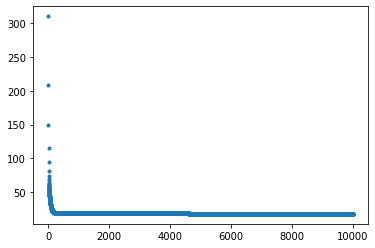

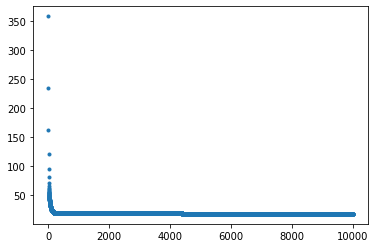

In [186]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(optimizer1.cost_history)), optimizer1.cost_history, '.')
plt.show()
plt.plot(np.arange(len(optimizer2.cost_history)), optimizer2.cost_history, '.')
plt.show()